In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

In [2]:
import options_wizard as ow

stocks = [
    "AAPL", "MSFT", "NVDA", "GOOG", "GOOGL",
    #"AMZN", "META", "AVGO", "TSLA", "PEP",
    #"COST", "NFLX", "ADBE", "CSCO", "AMD",
    #"INTC", "LIN", "TXN", "QCOM", "AMAT"
]
for stock in stocks.copy():
    if stock not in available_ticks:
        print(f"Removing {stock} from universe - data not available")
        stocks.remove(stock)

universe = ow.Universe(stocks)
data_manager = ow.DataManager(universe, load_lazy=True)

In [3]:
ow.Transformer(data_manager)('scale_by_splits')
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('drop_stale_options', volume_threshold=100)
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', test_size=0.35, drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')

In [4]:
ow.Features(data_manager)('iv_rv_ratio')
ow.Features(data_manager)('term_structure_slope', near_expiry_days=10, far_expiry_days=30)
ow.Features(data_manager)('mac_vol', lookback_short=5, lookback_long=15)
ow.Features(data_manager)('days_to_earnings')
ow.Features(data_manager)('days_since_earnings')

In [5]:
ow.Strategy(data_manager)(
    'ratio_spread',
    entry_ttm=90,
    ttm_tol=10,
    delta_long=0.35,
    delta_short=0.15,
    short_ratio=3,
    delta_tol=0.05,
    call_put="p",
    hold_period=45,
    position=-1
)

In [6]:
ow.Features(data_manager)('prepare_data')
data_manager.execute_pipeline(retain_data=True, save_data=False)

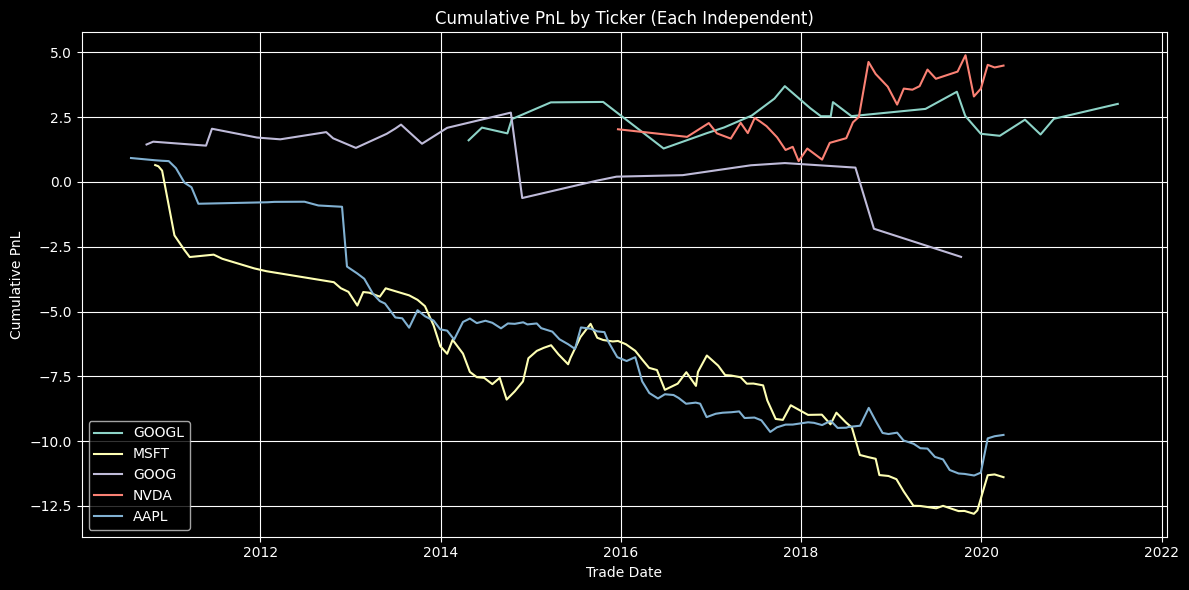

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# Assume data_manager.outputs is already defined
outputs = data_manager.outputs

# Create a figure
plt.figure(figsize=(12, 6))

# Iterate through each ticker independently
for ticker, df in outputs.items():
    # Sort by date
    df = df.sort_index().dropna(subset=['combined_pnl'])

    # Compute cumulative PnL starting from zero
    cum_pnl = 1 + df['combined_pnl'].cumsum()

    # Plot each ticker separately (no merging)
    plt.plot(df.index, cum_pnl, label=ticker)

# Format the plot
plt.title("Cumulative PnL by Ticker (Each Independent)")
plt.xlabel("Trade Date")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
